<a href="https://colab.research.google.com/github/iagomauricioo/data_science/blob/main/mapa_ok_com_api_places_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

In [ ]:
from google.colab import userdata
API_KEY = userdata.get('API_KEY')

In [ ]:
def get_places(location, place_type):
    """Obtém os lugares próximos de uma localização específica para um tipo específico."""
    endpoint = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {
        'location': location,
        'radius': radius,
        'type': place_type,
        'key': API_KEY
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        return response.json().get('results', [])
    else:
        print(f"Erro na requisição para {place_type}: {response.status_code}")
        return []

def count_places(city, place_name, places, city_place_counts, place_counts):
    """Conta os lugares obtidos por cidade e tipo de estabelecimento."""
    city_place_counts[city][place_name] += len(places)
    place_counts[place_name] += len(places)

def add_heat_data(places, place_name, heat_data):
    """Adiciona dados ao mapa de calor."""
    for place in places:
        lat = place['geometry']['location']['lat']
        lng = place['geometry']['location']['lng']
        heat_data[place_name].append([lat, lng])

def add_markers_to_map(places, place_name, map_obj):
    """Adiciona marcadores ao mapa."""
    for place in places:
        lat = place['geometry']['location']['lat']
        lng = place['geometry']['location']['lng']
        name = place['name']
        address = place.get('vicinity', 'Endereço não disponível')
        # Aqui você pode definir o ID do gráfico que deseja usar
        graph_id = place['place_id']
        popup_content = f"""
        <b>{name}</b><br>{address}<br>
        <button onclick="showGraph('{graph_id}')" style="display:inline-block; padding:5px 10px; background-color:#007bff; color:white; text-align:center; text-decoration:none; border-radius:5px;">
            Ver Gráfico
        </button>
        """
        folium.CircleMarker(
            location=[lat, lng],
            radius=7,
            color='transparent',  # Borda transparente
            fill=True,
            fill_color='transparent',  # Preenchimento transparente
            fill_opacity=0,  # Opacidade de preenchimento zero
            tooltip=name,
            popup=folium.Popup(popup_content, max_width=300)
        ).add_to(map_obj)

def add_map_by_establishment(map_obj, heat_data):
    """Adiciona camadas de mapa de calor para cada tipo de estabelecimento."""
    for place_name, data in heat_data.items():
        HeatMap(data, gradient={0.4: places_types[place_name]['color'], 0.65: places_types[place_name]['color'], 1: places_types[place_name]['color']}).add_to(map_obj)

def add_legend(map_obj):
    """Adiciona a legenda ao mapa."""
    legend_html = '''
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 200px;
        height: 150px;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:14px;
        ">
        &nbsp; <b>Legenda</b> <br>
        &nbsp; <i class="fa fa-circle" style="color:#FFD700"></i>&nbsp; Resorts e Hotéis <br>
        &nbsp; <i class="fa fa-circle" style="color:#FF4500"></i>&nbsp; Restaurantes e Bares <br>
        &nbsp; <i class="fa fa-circle" style="color:#FF0000"></i>&nbsp; Supermercados e Lojas de Conveniência <br>
        &nbsp; <i class="fa fa-circle" style="color:#0000FF"></i>&nbsp; Feiras e Mercados Locais <br>
    </div>
    '''
    map_obj.get_root().html.add_child(folium.Element(legend_html))

def add_modal(map_obj):
    """Adiciona um modal HTML ao mapa."""
    modal_html = '''
    <div id="graphModal" class="modal" style="display:none; position:fixed; top:0; left:0; width:100%; height:100%; overflow:auto; background-color:rgb(0,0,0); background-color:rgba(0,0,0,0.4); z-index:9999;">
        <div class="modal-content" style="background-color:#fefefe; margin:15% auto; padding:20px; border:1px solid #888; width:80%;">
            <span class="close" onclick="document.getElementById('graphModal').style.display='none'" style="color:#aaa; float:right; font-size:28px; font-weight:bold;">&times;</span>
            <canvas id="graphCanvas" width="400" height="400"></canvas>
        </div>
    </div>
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    <script>
        function showGraph(graph_id) {
            document.getElementById('graphModal').style.display = 'block';
            var ctx = document.getElementById('graphCanvas').getContext('2d');
            var chart = new Chart(ctx, {
                type: 'bar',
                data: {
                    labels: ['Qtd. Côco Comprado', 'Preço', 'Margem de Lucro', 'Categoria 4'],
                    datasets: [{
                        label: 'Dados do Gráfico',
                        data: [20, 13, 18, 10],
                        backgroundColor: [
                            'rgba(255, 99, 132, 0.2)',
                            'rgba(54, 162, 235, 0.2)',
                            'rgba(255, 206, 86, 0.2)',
                            'rgba(75, 192, 192, 0.2)'
                        ],
                        borderColor: [
                            'rgba(255, 99, 132, 1)',
                            'rgba(54, 162, 235, 1)',
                            'rgba(255, 206, 86, 1)',
                            'rgba(75, 192, 192, 1)'
                        ],
                        borderWidth: 1
                    }]
                },
                options: {
                    scales: {
                        y: {
                            beginAtZero: true
                        }
                    }
                }
            });
        }
    </script>
    '''
    map_obj.get_root().html.add_child(folium.Element(modal_html))

In [ ]:
def generate_excel():
  #TO DO

In [ ]:
locations = {
    'Marechal Deodoro': '-9.7095,-35.8964',
    'Barra de São Miguel': '-9.8405,-35.9027'
}
radius = 5000  # Raio de pesquisa em metros

places_types = {
    'Resorts e Hotéis': {'type': 'lodging', 'color': '#FFD700'},  # Amarelo
    'Restaurantes e Bares': {'type': 'restaurant', 'color': '#FF4500'},  # Laranja
    'Supermercados e Lojas de Conveniência': {'type': 'convenience_store', 'color': '#FF0000'},  # Vermelho
    'Feiras e Mercados Locais': {'type': 'grocery_or_supermarket', 'color': '#0000FF'}  # Azul
}

# Inicializa o mapa
map_marechal_barra = folium.Map(location=[-9.7750, -35.8990], zoom_start=12)

heat_data = {key: [] for key in places_types}
place_counts = {key: 0 for key in places_types}
city_place_counts = {city: {key: 0 for key in places_types} for city in locations}

In [ ]:
# Processa cada cidade e tipo de estabelecimento
for city, location in locations.items():
    for place_name, info in places_types.items():
        place_type = info['type']
        color = info['color']
        places = get_places(location, place_type)
        count_places(city, place_name, places, city_place_counts, place_counts)
        add_heat_data(places, place_name, heat_data)
        add_markers_to_map(places, place_name, map_marechal_barra)

# Chamar funções para adicionar o mapa de calor e a legenda
add_map_by_establishment(map_marechal_barra, heat_data)
add_legend(map_marechal_barra)
add_modal(map_marechal_barra)

In [ ]:
map_marechal_barra.save('map_marechal_barra.html')

In [ ]:
map_marechal_barra

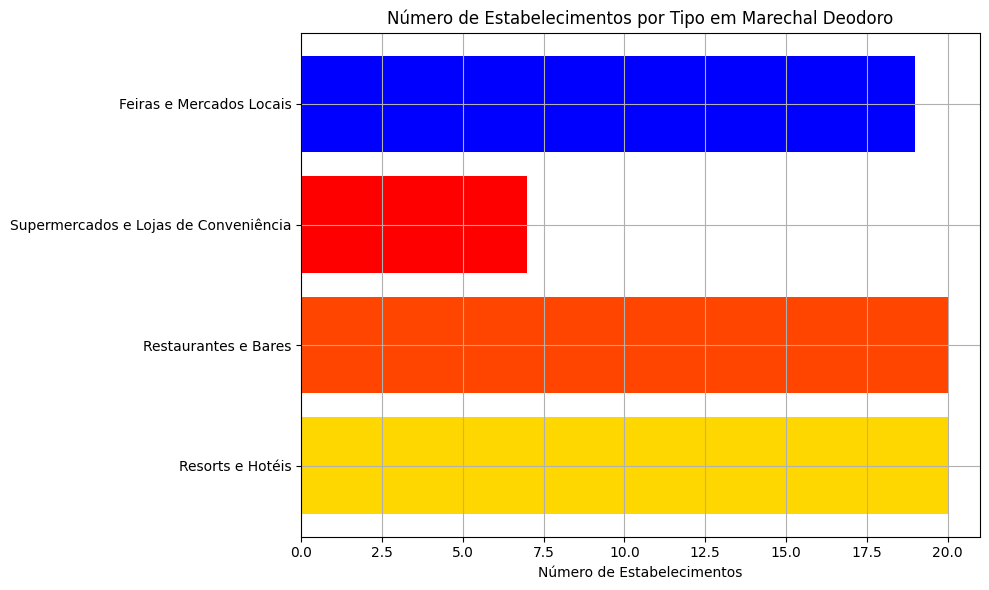

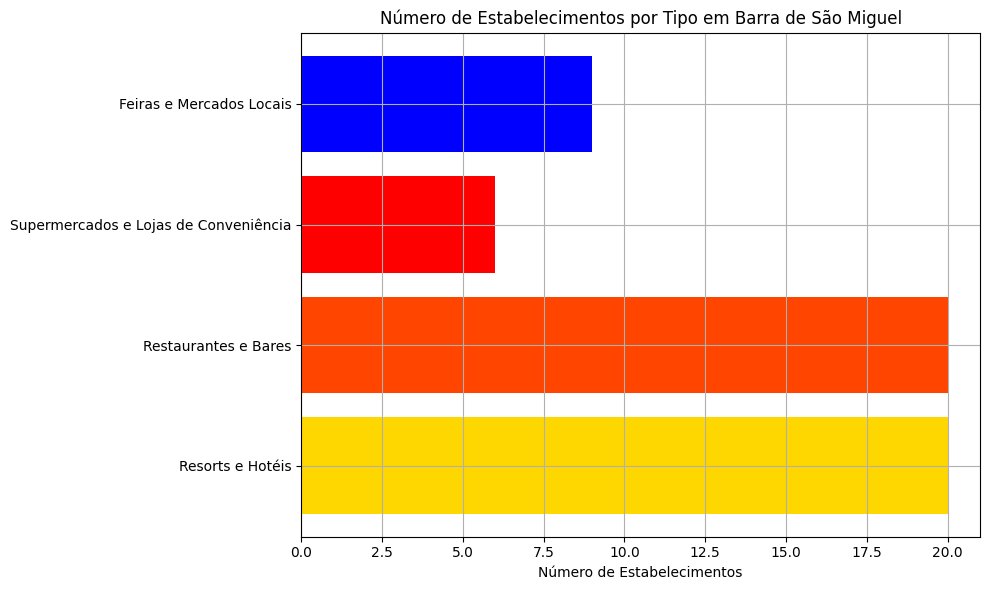

In [ ]:
for city, counts in city_place_counts.items():
    place_names = list(counts.keys())
    place_values = list(counts.values())

    plt.figure(figsize=(10, 6))
    plt.barh(place_names, place_values, color=[places_types[name]['color'] for name in place_names])
    plt.xlabel('Número de Estabelecimentos')
    plt.title(f'Número de Estabelecimentos por Tipo em {city}')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'estabelecimentos_por_tipo_{city}.png')
    plt.show()